In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

from anonymigraph.generation import role_infused_partition

# Get role_infused_partition model

In [3]:
c = 7  # Number of communities
n = 130  # Number of nodes per role
k = 12  # Number of roles
print(f"There are c*n*k: {c*n*k} nodes in the graph")

d_inter = 10
p = d_inter / (c*n*k) # Each node has roughly d_inter connections with any other node

# Random omega_role matrix drawn from a beta distribution to skew values slightly to 0 or 1
d_intra = 50
omega_role_triu = np.triu(np.random.beta(0.75, 0.75, size=(k, k)), k=1) # Generate upper triangle
omega_role = omega_role_triu + omega_role_triu.T # Make it symmetric
omega_role *= d_intra / (n*k/2) # Assumes that rnd dist has expectation of 1/2


adjacency_matrix, feature_matrix = role_infused_partition(c, n, p, omega_role, seed=42, return_networkx_graph=False)
G = role_infused_partition(c, n, p, omega_role, seed=42, return_networkx_graph=True)

There are c*n*k: 10920 nodes in the graph


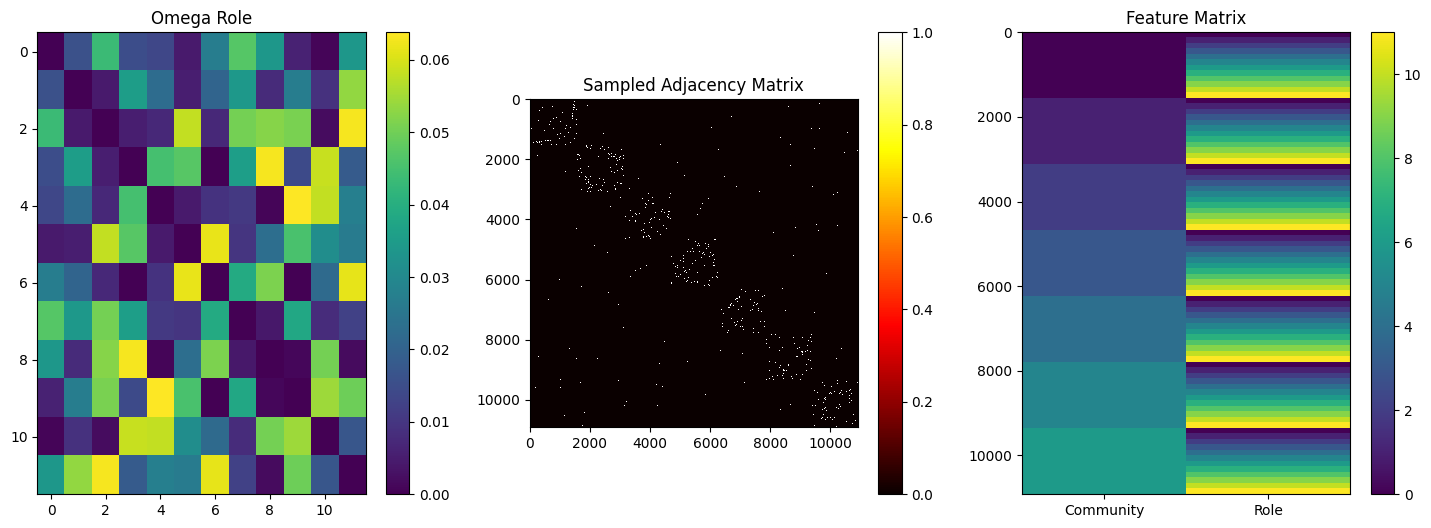

In [4]:
import numpy as np

plt.figure(figsize=(18, 6))


plt.subplot(1, 3, 1)
plt.imshow(omega_role, cmap='viridis', interpolation='nearest', aspect='auto')
plt.title("Omega Role")
plt.colorbar()
plt.grid(False)

plt.subplot(1, 3, 2)
plt.imshow(adjacency_matrix, cmap='hot', interpolation='nearest')
plt.title("Sampled Adjacency Matrix")
plt.colorbar()
plt.grid(False)

plt.subplot(1, 3, 3)
plt.imshow(feature_matrix, cmap='viridis', interpolation='nearest', aspect='auto')
plt.title("Feature Matrix")
plt.colorbar()
plt.grid(False)
plt.xticks(np.arange(2), ['Community', 'Role'])

plt.show()

# Predicting Communities Labels

Assumes that a very high (99.5%) percentage of communities labels are missing from most nodes.

On average there are (1-percentage_missing)*n*k = 7.8 nodes with their community label not missing per community of n*k=1560 nodes.
Accuracy when predicting the most frequent label in 2-hop: 0.960. The Baseline of a simple constant label 0 guesser is 1/c = 0.143


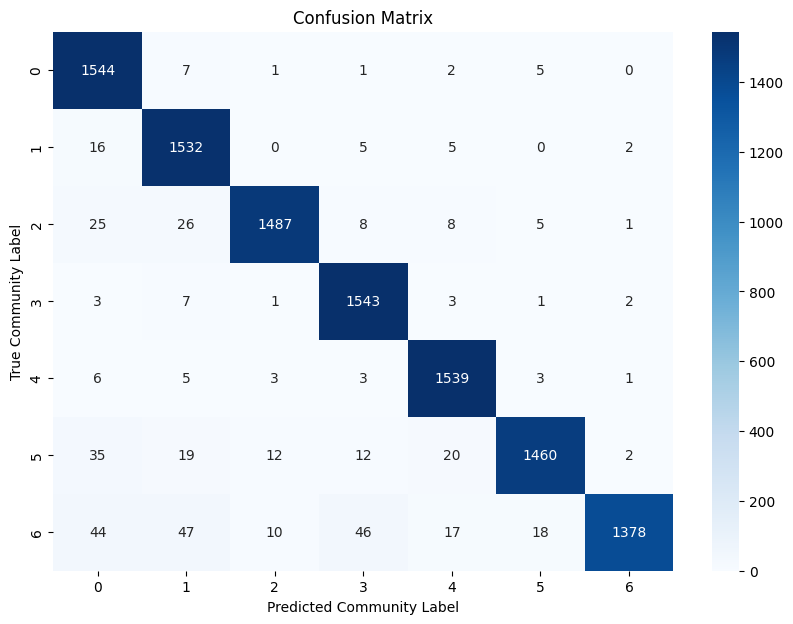

In [5]:
def obfuscate_features(feature_matrix, percentage_missing):
    rows, cols = feature_matrix.shape
    for col in range(cols):
        num_missing = int(rows * percentage_missing)
        indices = np.random.choice(rows, num_missing, replace=False)
        for idx in indices:
            feature_matrix[idx, col] = np.nan

    return feature_matrix


def predict_community_labels(adj_matrix, feature_matrix, d):
    n = adj_matrix.shape[0]
    predicted_labels = np.copy(feature_matrix[:, 0])

    d_hop_adj = np.linalg.matrix_power(adj_matrix, d)
    for i in range(n):
        if np.isnan(predicted_labels[i]):
            # Get d-hop neighbors
            neighbors = np.nonzero(d_hop_adj[i])[0]
            neighbor_labels = feature_matrix[neighbors, 0]

            # Remove NaNs and get most frequent label
            valid_labels = neighbor_labels[~np.isnan(neighbor_labels)]
            if valid_labels.size > 0:
                predicted_labels[i] = np.bincount(valid_labels.astype(int)).argmax()
            else:
                predicted_labels[i] = 0

    return predicted_labels


def evaluate_model(predicted_labels, true_labels):
    correct = np.sum((predicted_labels == true_labels) & (~np.isnan(true_labels)))
    total = np.sum(~np.isnan(true_labels))
    accuracy = correct / total if total > 0 else 0
    return accuracy


# Obfuscate the feature matrix with high missing values
percentage_missing = 0.995 #
print(f"On average there are (1-percentage_missing)*n*k = {(1-percentage_missing)*n*k:.1f} nodes with their community label not missing per community of n*k={n*k} nodes.")
obfuscated_feature_matrix = obfuscate_features(np.copy(feature_matrix), percentage_missing)

# Predict community labels
d_hop = 2  # d-hop neighborhood
true_labels = feature_matrix[:, 0]
predicted_labels = predict_community_labels(adjacency_matrix, obfuscated_feature_matrix, d_hop)

# Evaluate the model
accuracy = evaluate_model(predicted_labels, true_labels)
print(f"Accuracy when predicting the most frequent label in {d_hop}-hop: {accuracy:.3f}. The Baseline of a simple constant label 0 guesser is 1/c = {1/c:.3f}")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Community Label')
plt.xlabel('Predicted Community Label')
plt.show()
